#  Examples - Neuropsychiatric traits

This notebook identifies and examines example neuropsychiatric traits that have significant network colocalization of common and rare variants. 

**Inputs:**
* Supplemental Table 1 - Input Information (`STable1.tsv`)
* Supplemental Table 2 - NetColoc Results (`STable2.tsv`)
* Neuropsychiatric traits NDEx UUIDs (`uuid_list.txt`)


**Figures generated:**
- Figure 6A
- Figure 6B Edgelist and Node information

## Set Up

In [4]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [5]:
cwd = os.getcwd()
sys.path.append(os.path.join(cwd, '../carva'))
from network_utils import *
from geneset_utils import *
from hierarchy_utils import *


In [6]:
datadir=os.path.join(cwd, '..')
outdir=os.path.join(datadir, 'outputs')

In [7]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = os.path.join(datadir, 'Reference_Data/Arial.TTF')
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
blue='#6ec1e0'
green='#5fad56'
shared='#af3800'
binary='#00606f'
purple='#441f5d'
raspberry='#b4436c'

## Import Data

In [92]:
domain_info = pd.read_csv(os.path.join(datadir, 'outputs/STable1.tsv'), sep='\t', usecols=['Mapped EFO', 'Trait Type', 
                                                                              'Biological Domain', 'Mapped Trait']).drop_duplicates()
domain_info.columns = ['TRAIT', 'EFO', 'trait_type', 'Domain']

In [93]:
coloc_df = pd.read_csv(os.path.join(outdir, 'STable2.tsv'), sep='\t')
best_df = coloc_df[coloc_df['Optimal COLOC']]

In [94]:
best_df = best_df.reset_index().merge(domain_info.loc[:, ('EFO', 'Domain', 'trait_type')], on=['EFO'], how='left')

In [95]:
def get_trait_pair(df):
    df['trait_pair'] = df['Rare Study'].astype(int).astype(str) + '_' + df['EFO'] +'_' +df['Common Study'] +'_'+ df['EFO']
    return df

In [96]:
best_df = get_trait_pair(best_df)

In [97]:
npd_df_full = best_df[best_df.EFO.isin(domain_info[domain_info.Domain.isin(['Neurological', 'Psychiatric'])].EFO.values)]
npd_df = npd_df_full[(npd_df_full.Log2SizeOE >= 0 ) & (npd_df_full['COLOC p'] < 0.01) ].copy()
print('Total Neuropsychiatric Traits:', len(npd_df_full))
print('Neuropsychiatric Traits with at least Moderate Coloc:', len(npd_df))

Total Neuropsychiatric Traits: 21
Neuropsychiatric Traits with at least Moderate Coloc: 14


In [98]:
efo_list = npd_df.EFO.values

### Load subnetworks

In [99]:
uuid_list = pd.read_csv(os.path.join(cwd, '../outputs/uuid_list.txt'), sep='\t')
uuid_list['EFO'] = uuid_list.TraitR.apply(lambda z: z.split('_', 1)[-1])
uuid_dict = uuid_list.set_index('EFO')['uuid'].to_dict()

In [100]:
username=getpass('Username:')
password = getpass('Password')

Username:········
Password········


In [102]:
node_lists = {}
for efo in efo_list:
    uuid = uuid_dict[efo]
    G = load_network(uuid, use_password=True, ndex_password=password, ndex_user=username, verbose=False)
    node_lists[efo] = [int(n) for n in G.nodes()]

### Load Features

In [116]:
input_feat = pd.read_csv(os.path.join(datadir, 'outputs/STable1.tsv'), sep='\t').drop_duplicates()


In [117]:
input_feat['StudyTrait'] = input_feat['Study Identifier'].astype(str) + '_' + input_feat['Mapped EFO']

## Figure 6A

In [118]:
trait_labels={'autism spectrum disorder':'ASD', 'Alzheimer disease':'AD',
       'whole-brain volume':'WBV', 'bipolar disorder':'BD', 'multiple sclerosis':'MS',
       'obsessive-compulsive disorder':'OCD', 'insomnia':'Insomnia', 'epilepsy':'Epilepsy',
       'schizophrenia':'SCZ', 'carpal tunnel syndrome':'Carpal Tunnel Synd.', 'partial epilepsy':'Partial Epilepsy',
       'migraine disorder':'Migraine', 'Headache': 'Headache', 'Vertigo':'Vertigo'}

In [119]:
plot_df = npd_df.loc[:, ['EFO', 'Log2SizeOE', 'nRare', 'nCommon', 'Trait', 'Domain', 'trait_type', 'nShared', 'COLOC -logp']]

In [120]:
plot_df['TRAIT'] = plot_df['Trait'].map(trait_labels)

In [121]:
plot_df['Domain'] = plot_df.Domain.map({'Psychiatric': 1, 'Neurological':2})
plot_df['trait_type'] = plot_df.trait_type.map({'CC':1, 'Q': 0, 'Categorical':1, 'Continuous':0, 1:1, 0:0})
plot_df['nRare'] = plot_df.nRare.apply(lambda x: np.log10(x))
plot_df['nCommon'] = plot_df.nCommon.apply(lambda x: np.log10(x))
plot_df['plotq'] = plot_df['COLOC -logp'].apply(lambda x: min(x, 50))

In [122]:
plot_df = plot_df.sort_values('Log2SizeOE', ascending=False)

Text(0, 0.5, 'COLOC Score')

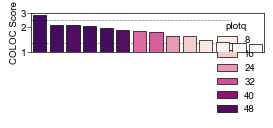

In [123]:
_ = plt.figure(figsize=(3, 0.5))
plt.hlines(y=[np.log2(1.3), np.log2(2.5)], xmin=-0.5, xmax=11.5, color='grey', linestyle='--', linewidth=0.5
          )
sns.barplot(plot_df, x='TRAIT', y='Log2SizeOE', hue='plotq', palette='RdPu', edgecolor='black', zorder=10)
_ = plt.xticks([])
_ = plt.xlabel('')
_ = plt.yticks([0, 1, np.log2(3)], labels=[1, 2, 3])
plt.ylabel('COLOC Score')


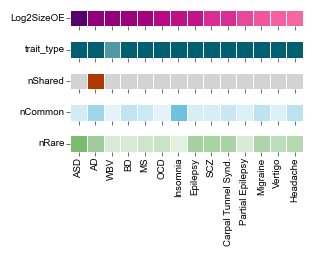

In [124]:
import matplotlib as mpl
_, axs = plt.subplots(ncols=1, nrows=5, sharex=True, gridspec_kw={'height_ratios':[1,1,1,1,1], 'hspace':0.1}, 
                     figsize=(3, 2))

metrics = [['Log2SizeOE'], ['trait_type'], ['nShared'], ['nCommon'], ['nRare']]
cmaps = ['RdPu', 
         sns.blend_palette(['#509aa5', binary], as_cmap=True), 
         sns.blend_palette(['lightgrey', shared], as_cmap=True), 
         sns.blend_palette(['white', blue], as_cmap=True), 
         sns.blend_palette(['white', green], as_cmap=True),
         sns.blend_palette(['white', '#F78154'], as_cmap=True),
         'vlag']
norms = [mpl.colors.Normalize(vmin=-1, vmax=np.log2(3)),
        None,
        None,
        mpl.colors.Normalize(vmin=0, vmax=2.5),
        mpl.colors.Normalize(vmin=0, vmax=2.5),
        None,
        None]


ylabels=['COLOC Score', 'Trait Type', 'Shared Genes', 'CVGs', 'RVGs']

for i in range(0, 5):
    sns.heatmap(plot_df.loc[:, ['TRAIT'] + metrics[i]].set_index('TRAIT').T, ax=axs[i], cmap=cmaps[i], square=True, 
           linecolor='white', linewidth=0.5, norm=norms[i], cbar=False)
    axs[i].tick_params(axis='y', rotation=0)
    axs[i].set_xlabel('')


In [113]:
npd_df.sort_values(by='COLOC p', ascending=True).loc[:, ['Trait', 'COLOC p', 'Log2SizeOE']].head(3)

,Trait,COLOC p,Log2SizeOE
45,autism spectrum disorder,2.740000e-266,1.494694
349,Alzheimer disease,2.162000e-87,1.119217
351,bipolar disorder,1.940000e-58,1.042778


## Trait Similarity

In [60]:
## Load all_zscores
def load_z(trait, datadir, transform, norm, rorc):
    df = pd.read_csv(os.path.join(datadir, f'{trait}_z_{rorc}V_q_{transform}_{norm}.tsv'), sep='\t', header=None,
                    index_col=0, names=['z']).dropna()
    return df

def load_all_scores(df, datadir, rorc):
    allz = {}
    if rorc == 'C':
        other = 'TraitR'
    else:
        other = 'TraitC'
    for i, t in tqdm(enumerate(list(df[f'Trait{rorc}'].values))):
        if rorc == 'R':
            other = 'TraitC'
            allz[f'{t}_{df[other].values[i]}'] = load_z(t, datadir, 'neglog10', 'sum', rorc=rorc).z.to_dict()
        else:
            other = 'TraitR'
            allz[f'{df[other].values[i]}_{t}'] = load_z(t, datadir, 'neglog10', 'sum', rorc=rorc).z.to_dict()
    z = pd.DataFrame.from_dict(allz)
    return z

In [57]:
npd_df['TraitR'] = npd_df['Rare Study'].astype(int).astype(str)+ '_' + npd_df['EFO']
npd_df['TraitC'] = npd_df['Common Study']+ '_' + npd_df['EFO']
npd_df['trait_pair'] = npd_df['TraitR'] + '_' + npd_df['TraitC']

In [61]:
zR = load_all_scores(npd_df, os.path.join(datadir, 'outputs/'), 'R').dropna()
zC = load_all_scores(npd_df, os.path.join(datadir, 'outputs/'), 'C').dropna()
z_coloc = zR * zC
z_coloc_order = z_coloc.columns

14it [00:00, 118.50it/s]
14it [00:00, 118.83it/s]


In [87]:
npd_df.columns

Index(['EFO', 'Trait', 'Common Study', 'Rare Study', 'Analysis Set', 'nCommon',
       'nRare', 'nShared', 'pShared', 'Network', 'Observed Size',
       'Expected Size', 'Log2SizeOE', 'COLOC Score', 'COLOC p', 'COLOC -logp',
       'Optimal COLOC', 'Observed Size PC22', 'Expected Size PC22',
       'Log2SizeOE PC22', 'COLOC Score PC22', 'COLOC P PC22',
       'COLOC -logp PC22', 'Observed Size HN', 'Expected Size HN',
       'Log2SizeOE HN', 'COLOC Score HN', 'COLOC P HN', 'COLOC -logp HN',
       'Observed Size ST', 'Expected Size ST', 'Log2SizeOE ST',
       'COLOC Score ST', 'COLOC P ST', 'COLOC -logp ST', 'TraitR', 'TraitC',
       'trait_pair'],
      dtype='object')

In [62]:
def get_similarities_df(npd_df, z_df, node_lists):
    cosine_sims = {}
    for tp, efo in zip(npd_df.trait_pair.values, npd_df.EFO.values):
        cosine_sims[tp] = {}
        for tp1, efo1 in zip(npd_df.trait_pair.values, npd_df.EFO.values):
            cosine_sims[tp][tp1] = cosine_similarity_of_subnetworks(z_df[tp], z_df[tp1], 
                                                                    node_lists[efo], node_lists[efo1])[0,1]
    out_sims = pd.DataFrame(cosine_sims).melt(var_name='trait2', value_name='Cosine', ignore_index=False).reset_index(names=['trait1'])
    #print(out_sims)
    out_sims['trait1'] = out_sims['trait1'].map(npd_df.set_index('trait_pair')['Trait'].to_dict())
    out_sims['trait2'] = out_sims['trait2'].map(npd_df.set_index('trait_pair')['Trait'].to_dict())
    out_sims['traitA'] = out_sims.apply(lambda z: sorted([z.trait1, z.trait2])[0], axis=1)
    out_sims['traitB'] = out_sims.apply(lambda z: sorted([z.trait1, z.trait2])[1], axis=1)
    out_sims = out_sims[out_sims.trait1 != out_sims.trait2]
    return out_sims.drop(columns=['trait1', 'trait2']).drop_duplicates(subset=['traitA', 'traitB'])


def cosine_similarity_of_subnetworks(z1, z2, sub1=None, sub2=None):
    gene_df = pd.DataFrame({'z1':z1, 'z2':z2}).fillna(0)
    if sub1 is not None:
        gene_df = gene_df.loc[list(set(sub1).union(set(sub2)))]
    return cosine_similarity(np.array(gene_df).T)
    

In [63]:
out_sims = get_similarities_df(npd_df, z_coloc, node_lists)
out_rare = get_similarities_df(npd_df, zR, node_lists)
out_common = get_similarities_df(npd_df, zC, node_lists)

In [64]:
out = out_rare.merge(out_common, on=['traitA', 'traitB'], suffixes=['_R', '_C']).merge(out_sims, on=['traitA', 'traitB'])

### Figure 6B Data - Export similarity node and edge information 

To be visualized in Cytoscape

In [65]:
out.to_csv(os.path.join(datadir, 'outputs/npd_similiarities.csv'), index=False)

In [66]:
npd_df.loc[:, ('Trait', 'Log2SizeOE', 'COLOC -logp', 'nCommon', 'nRare', 'nShared')].to_csv(os.path.join(datadir, 'outputs/npd_similiarities_nodes.csv'), index=False)